# **Modèle personnel**

### **Importation des bibliothèques**

In [1]:
import os  # Manipulations de fichiers
import shutil  # Pour supprimer un dossier non vide
import random  # Utilisé lors de la séparation train/test
from math import ceil  # Utilisé lors de la séparation train/test
import numpy as np  # Manipulation d'arrays et utilisation de np.argmax
import time  # Mesures des durées d'éxécution

# Désactivation des messages de debugging de tensorflow.
# Doit être exécuté avant les imports de tensorflow.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Préparation des données, création du modèle, data augmentation
from tensorflow import device
from tensorflow.config import list_physical_devices
from tensorflow.keras.utils import image_dataset_from_directory, set_random_seed
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Calcul des métriques
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score

# Visualisations
import matplotlib.pyplot as plt

### **Mesure de la durée d'exécution du notebook**

In [2]:
t_notebook = time.time()

### **Création d'une seed pour stabiliser les résultats.**

Malgré ceci, les calculs réalisés à l'aide d'une carte graphique peuvent parfois amener un peu de variabilité.

In [3]:
seed = 42
# Paramétrer la seed de numpy, tensorflow et python : 
set_random_seed(seed)
random.seed(seed)

## **A). Création d'un répertoire avec séparation train/test**

In [4]:
# Proportion des échantillons à utiliser pour le train
split_ratio = 0.8

# Répertoire source
#input_folder = "dogs_only"
#input_folder = "dogs_small_proc"
#input_folder = "dogs_small_proc_white"
input_folder = "dogs_small"

output_folder = input_folder + "_splited"

debut = time.time()  # Heure de début du traitement

# Nombre de sous dossiers, autrement dit : nombre de classe
# je mets cette valeur de côté, on en aura besoin pour la structure du modèle
nb_classes = len(os.listdir(input_folder))

# Si le dossier existe déjà
# suppression du dossier et de son contenu avec shutil
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)

# Créer les dossiers train et test dans le dossier de sortie
train_folder = os.path.join(output_folder, 'train')
test_folder = os.path.join(output_folder, 'test')
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Parcourir les sous-dossiers du dossier d'origine
for label_folder in os.listdir(input_folder):
    label_path = os.path.join(input_folder, label_folder)
    if os.path.isdir(label_path):
        # Liste des fichiers dans le sous-dossier
        files = os.listdir(label_path)
        # Calculer le nombre de fichiers à utiliser pour l'entraînement
        train_count = ceil(len(files) * split_ratio)
        # Mélanger la liste des fichiers de manière aléatoire
        random.shuffle(files)
        
        # Diviser les fichiers entre train et test
        train_files = files[:train_count]
        test_files = files[train_count:]

        # Créer les sous-dossiers correspondants dans les dossiers train et test
        train_label_folder = os.path.join(train_folder, label_folder)
        test_label_folder = os.path.join(test_folder, label_folder)
        os.makedirs(train_label_folder, exist_ok=True)
        os.makedirs(test_label_folder, exist_ok=True)

        # Copier les fichiers dans les sous-dossiers correspondants
        for file in train_files:
            shutil.copy(os.path.join(label_path, file), os.path.join(train_label_folder, file))
        
        for file in test_files:
            shutil.copy(os.path.join(label_path, file), os.path.join(test_label_folder, file))

path = output_folder+"/train"
path_test = output_folder+"/test"

print(f"Durée de création : {(time.time() - debut):.2f} s")

Durée de création : 13.82 s


## **B). Création des datasets tensorflow**

In [5]:
# Taille des batchs des datasets
batch_size = 32

# Si les images en entrée n'ont pas la bonne taille,
# elles seront redimensionnées à cette taille
images_size = (224, 224)

def dataset_fct(path, validation_split=0, data_type=None, img_size=(224, 224)) :
    dataset = image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=img_size, shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [6]:
debut = time.time()  # Heure de début du traitement

dataset_train = dataset_fct(path, validation_split=0.25, data_type='training', img_size=images_size)
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation', img_size=images_size)
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None, img_size=images_size)

print(f"\nDurée de création : {(time.time() - debut):.2f} s")

Found 472 files belonging to 3 classes.
Using 354 files for training.
Found 472 files belonging to 3 classes.
Using 118 files for validation.
Found 117 files belonging to 3 classes.

Durée de création : 4.03 s


### **Exemple d'image du dataset de train**

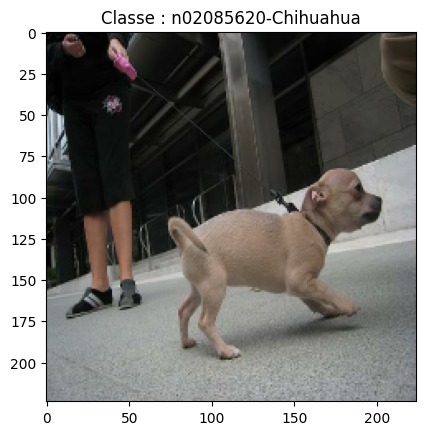

In [7]:
# Récupération du nom des classes (nom des sous dossiers)
class_names = os.listdir(input_folder)

# Sortir un batch du dataset
for images, labels_encoded in dataset_train.take(1):
    # Convertir les labels encodés en indices de classe
    class_indices = np.argmax(labels_encoded, axis=1)  # np.argmax sert à trouver l'indice de la valeur la plus élevée
                                                       # labels_encoded qui est onehot encodé.
                                                       # ex : argmax([[0, 1, 0]], axis=1).numpy()[0] retourne 1
                                                       # (les indices commencent à 0)
    
    # Récupérer les noms de classe correspondants aux indices
    class_labels = [class_names[i] for i in class_indices]

# Afficher la première image du batch du dataset de train
plt.imshow(images[0].numpy().astype("uint8"))
plt.title(f"Classe : {class_labels[0]}")
plt.show()


## **C). Modèle de base**

### **1). Création et entraînement du modèle**

#### **Fonction de création**

Nous allons nous baser sur l'architecture de VGG16, que l'on peut retrouver [ici](https://github.com/keras-team/keras-applications/blob/master/keras_applications/vgg16.py).

In [8]:
def create_model_base() :
    
    # Taille des images en entrée
    # On reprend bien la taille qu'on avait spécifiée
    # lors de la création de nos datasets
    input_shape = (224, 224, 3)

    # Structure du modèle
    model = Sequential([

    # BLOC 1
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape, name='block1_conv1'),
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', name='block1_conv2'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block1_pool'),
    
    # BLOC 2
    Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', name='block2_conv1'),
    Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', name='block2_conv2'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block2_pool'),

    # BLOC 3    
    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', name='block3_conv1'),
    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', name='block3_conv2'),
    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', name='block3_conv3'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block3_pool'),

    # BLOC 4    
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='block4_conv1'),
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='block4_conv2'),
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='block4_conv3'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block4_pool'),

    # BLOC 5
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='block5_conv1'),
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='block5_conv2'),
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='block5_conv3'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block5_pool'),

    # Bloc de classification
    Flatten(name='flatten'),
    Dense(4096, activation='relu', name='fc1'),
    Dense(4096, activation='relu', name='fc2'),
    Dense(nb_classes, activation='softmax', name='predictions')  # nb_classes : nombre de classes, défini lors
                                                                 # de la création des répertoires train/test

    ], name='Base')

    # Compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    # Affichage de la structure du modèle
    print(model.summary())
    
    return model

#### **Création**

In [9]:
# Création du modèle
with device('/gpu:0'):    
    model_base = create_model_base()

Model: "Base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       295168 

#### **Création du callback**

In [10]:
model_base_save_path = "./model_perso_base_best_weights.h5"

checkpoint = ModelCheckpoint(model_base_save_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min'
             )

es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=5  # Nombre d'epoch sans amélioration à attendre
                               # avant d'interrompre l'entraînement
     )

callbacks_list_base = [checkpoint, es]

#### **Entraînement du modèle**

In [11]:
print("GPUs disponibles :", len(list_physical_devices('GPU')), "\n")

debut = time.time()  # Heure de début du traitement

with device('/gpu:0'): 
    history_base = model_base.fit(dataset_train,
                                  validation_data=dataset_val,
                                  batch_size=batch_size,  # On reprend bien le même batchsize que lors de la création des datasets
                                  epochs=50,
                                  callbacks=callbacks_list_base,
                                  verbose=1
                   )

print(f"\nDurée d'entraînement : {(time.time() - debut):.2f} s")

GPUs disponibles : 1 

Epoch 1/50


12/12 [==============================] - ETA: 0s - loss: 581.7133 - accuracy: 0.3023
Epoch 1: val_loss improved from inf to 1.09680, saving model to ./model_perso_base_best_weights.h5


/home/maxime/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 14s 470ms/step - loss: 581.7133 - accuracy: 0.3023 - val_loss: 1.0968 - val_accuracy: 0.3136
Epoch 2/50
11/12 [==========================>...] - ETA: 0s - loss: 1.1619 - accuracy: 0.4006
Epoch 2: val_loss improved from 1.09680 to 1.09004, saving model to ./model_perso_base_best_weights.h5
12/12 [==============================] - 4s 349ms/step - loss: 1.1615 - accuracy: 0.4011 - val_loss: 1.0900 - val_accuracy: 0.4492
Epoch 3/50
11/12 [==========================>...] - ETA: 0s - loss: 1.1055 - accuracy: 0.4205
Epoch 3: val_loss improved from 1.09004 to 1.08768, saving model to ./model_perso_base_best_weights.h5
12/12 [==============================] - 4s 357ms/step - loss: 1.1052 - accuracy: 0.4237 - val_loss: 1.0877 - val_accuracy: 0.4492
Epoch 4/50
11/12 [==========================>...] - ETA: 0s - loss: 1.0889 - accuracy: 0.4205
Epoch 4: val_loss improved from 1.08768 to 1.07475, saving model to ./model_perso_base_best_weights.h5
12/12 [======

### **2). Évaluation du modèle**

#### **Fonctions d'évaluation**

In [12]:
def show_train_metrics(history):
    
    # Accéder au dictionnaire contenant les métriques
    metrics_dict = history.history

    # Graphique des résultats d'entraînement :
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Tracer la courbe de perte d'entraînement et de validation
    ax1.plot(metrics_dict['loss'], label=f'Training Loss (dernier : {metrics_dict["loss"][-1]:.4f})')
    ax1.plot(metrics_dict['val_loss'], label=f'Validation Loss (dernier : {metrics_dict["val_loss"][-1]:.4f})')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend()
    ax1.set_title('\nTraining and Validation Loss\n', fontsize=14)
    ax1.grid(True, linestyle=':', alpha=0.8)

    # Tracer la courbe d'accuracy d'entraînement et de validation
    ax2.plot(metrics_dict['accuracy'], label=f'Training Accuracy (dernier : {metrics_dict["accuracy"][-1]*100:.2f}%)')
    ax2.plot(metrics_dict['val_accuracy'], label=f'Validation Accuracy (dernier : {metrics_dict["val_accuracy"][-1]*100:.2f}%)')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.legend()
    ax2.set_title('\nTraining and Validation Accuracy\n', fontsize=14)
    ax2.grid(True, linestyle=':', alpha=0.8)

    plt.show()

In [13]:
def show_metrics_and_matrix(model=None, dataset=None):
    
    """
    Cette fonction sert à afficher la matrice de confusion
    des prédictions réalisées par le modèle.
    Prend en entrée : 
    - Le modèle entraîné
    - Le dataset (de type tf.Dataset)
    """

    if not model or not dataset:
        print("Il faut préciser le modèle et le dataset")
        return

    # On crée les arrays qui vont contenir
    # les labels prédits et les labels réels
    pred_labels = np.array([])
    true_labels =  np.array([])

    # On va itérer par batch sur le dataset
    # pour récupérer à chaque fois les labels prédits et réels
    for x, y in dataset:
       # argmax(x, axis=-1) : retourne la position de la valeur max
       pred_labels = np.concatenate([pred_labels, np.argmax(model.predict(x, verbose=0), axis=-1)]) 
       true_labels = np.concatenate([true_labels, np.argmax(y.numpy(), axis=-1)])

    # Affichage des métriques
    print("=== Scores pour les prédictions ===")
    print(f"Accuracy score : {accuracy_score(true_labels, pred_labels):.3f}")
    # average='weighted' : prendre en compte l'importance de chaque classe
    # zero_division=0 : si une classe n'est pas du tout prédite, la précision sera fixée à 0
    print(f"Precision score : {precision_score(true_labels, pred_labels, average='weighted', zero_division=0):.3f}")
    print(f"Recall score : {recall_score(true_labels, pred_labels, average='weighted'):.3f}")
    print(f"F1 score : {f1_score(true_labels, pred_labels, average='weighted'):.3f}")
    print("===================================")

    # Création de la matrice de confusion
    cm = confusion_matrix(true_labels, pred_labels, normalize='pred')
    # Affichage de la matrice de confusion
    cmp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(10,10))
    plt.title("\nMatrice de confusion\n", fontsize=20)
    plt.xlabel("", fontsize=16)
    plt.ylabel("", fontsize=16)
    cmp.plot(ax=ax, cmap=plt.cm.PuBuGn)    

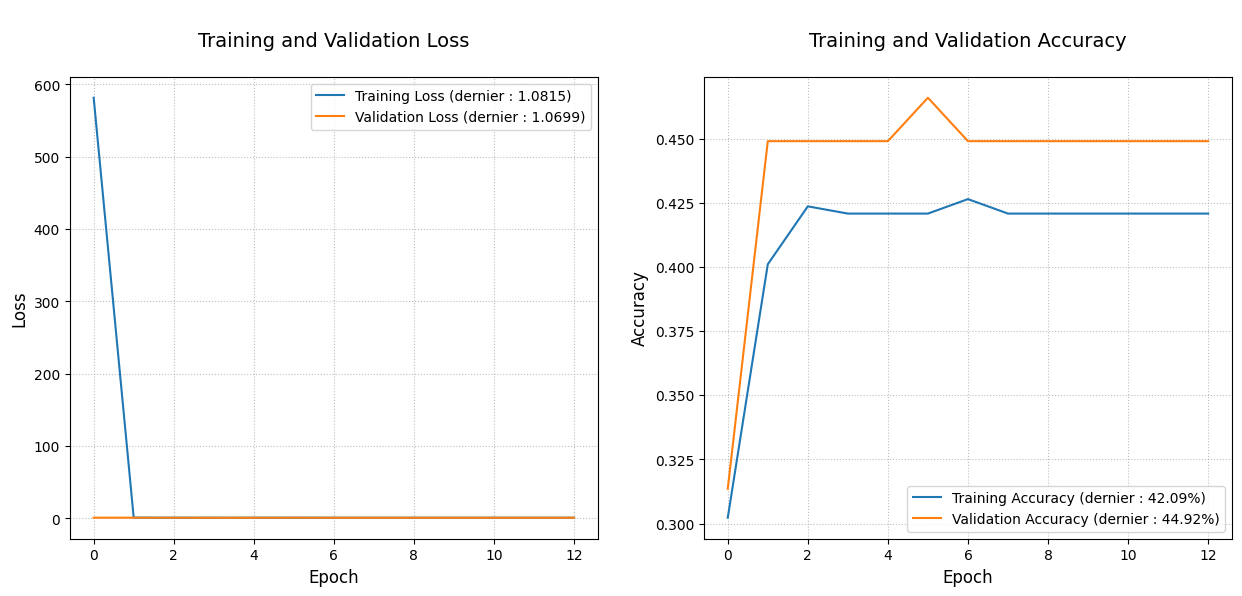

In [14]:
show_train_metrics(history=history_base)

In [15]:
# Score du dernier epoch
print("=== Dernier epoch ===")
loss, accuracy = model_base.evaluate(dataset_train, verbose=False)
print(f"Training Accuracy   : {accuracy:.3f}")
loss, accuracy = model_base.evaluate(dataset_val, verbose=False)
print(f"Validation Accuracy : {accuracy:.3f}")

# Score de l'epoch optimal
print("=== Epoch optimal ===")
# Chargement des poids optimaux
model_base.load_weights(model_base_save_path)
loss, accuracy = model_base.evaluate(dataset_val, verbose=False)
print(f"Validation Accuracy : {accuracy:.3f}")
loss, accuracy = model_base.evaluate(dataset_test, verbose=False)
print(f"Test Accuracy       : {accuracy:.3f}")

=== Dernier epoch ===
Training Accuracy   : 0.421
Validation Accuracy : 0.449
=== Epoch optimal ===
Validation Accuracy : 0.449
Test Accuracy       : 0.427


=== Scores pour les prédictions ===
Accuracy score : 0.427
Precision score : 0.183
Recall score : 0.427
F1 score : 0.256


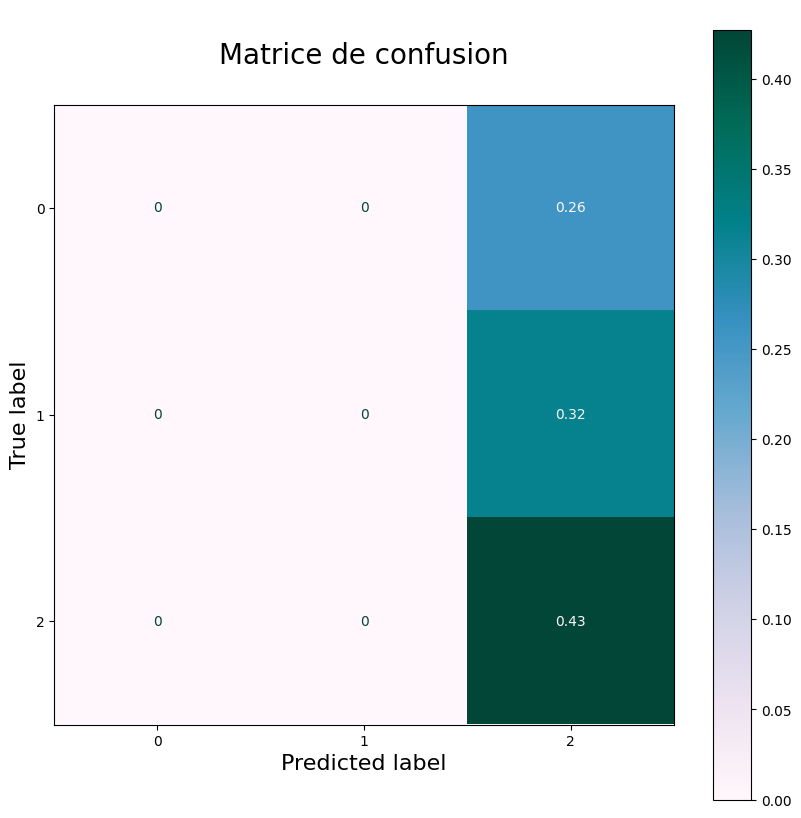

In [16]:
show_metrics_and_matrix(model=model_base, dataset=dataset_test)

## **D). Modèle optimisé**

### **1). Création et entraînement du modèle**

#### **Fonction de création**

- Nous allons encore nous baser sur l'architecture de VGG16, que l'on peut retrouver [ici](https://github.com/keras-team/keras-applications/blob/master/keras_applications/vgg16.py).<br>
- Nous allons ajouter une étape de data augmentation au début.

In [17]:
def create_model_opti() :
    
    # Taille des images en entrée
    # On reprend bien la taille qu'on avait spécifiée
    # lors de la création de nos datasets
    input_shape = (224, 224, 3)

    # Définition de l'étape de data augmentation
    data_augmentation = Sequential([RandomFlip("horizontal", input_shape=input_shape, name="RandomFlip"),
                                    RandomRotation(0.1, name="RandomRotation"),
                                    RandomZoom(0.1, name="RandomZoom")
                                   ], name='Augmentation')

    # Structure du modèle
    model = Sequential([

    # Étape de data augmentation
    data_augmentation,    
    
    # BLOC 1
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape, name='block1_conv1'),
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', name='block1_conv2'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block1_pool'),
    
    # BLOC 2
    Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', name='block2_conv1'),
    Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', name='block2_conv2'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block2_pool'),

    # BLOC 3    
    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', name='block3_conv1'),
    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', name='block3_conv2'),
    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', name='block3_conv3'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block3_pool'),

    # BLOC 4    
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='block4_conv1'),
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='block4_conv2'),
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='block4_conv3'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block4_pool'),

    # BLOC 5
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='block5_conv1'),
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='block5_conv2'),
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='block5_conv3'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block5_pool'),

    # Bloc de classification
    Flatten(name='flatten'),
    Dense(4096, activation='relu', name='fc1'),
    Dense(4096, activation='relu', name='fc2'),
    Dense(nb_classes, activation='softmax', name='predictions')  # nb_classes : nombre de classes, défini lors
                                                                 # de la création des répertoires train/test

    ], name='Opti')

    # Compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    # Affichage de la structure du modèle
    print(model.summary())
    
    return model

#### **Création**

In [18]:
# Création du modèle
with device('/gpu:0'):    
    model_opti = create_model_opti()

Model: "Opti"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Augmentation (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0      

#### **Création du callback**

In [19]:
model_opti_save_path = "./model_perso_opti_best_weights.h5"

checkpoint = ModelCheckpoint(model_opti_save_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min'
             )

es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=5  # Nombre d'epoch sans amélioration à attendre
                               # avant d'interrompre l'entraînement
     )

callbacks_list_opti = [checkpoint, es]

#### **Entraînement du modèle**

In [20]:
print("GPUs disponibles :", len(list_physical_devices('GPU')), "\n")

debut = time.time()  # Heure de début du traitement

with device('/gpu:0'): 
    history_opti = model_opti.fit(dataset_train,
                                  validation_data=dataset_val,
                                  batch_size=batch_size,  # On reprend bien le même batchsize que lors de la création des datasets
                                  epochs=50,
                                  callbacks=callbacks_list_opti,
                                  verbose=1
                   )

print(f"\nDurée d'entraînement : {(time.time() - debut):.2f} s")

GPUs disponibles : 1 

Epoch 1/50


11/12 [==========================>...] - ETA: 0s - loss: 409.2209 - accuracy: 0.4148
Epoch 1: val_loss improved from inf to 1.20232, saving model to ./model_perso_opti_best_weights.h5


/home/maxime/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 8s 429ms/step - loss: 406.9143 - accuracy: 0.4181 - val_loss: 1.2023 - val_accuracy: 0.4492
Epoch 2/50
11/12 [==========================>...] - ETA: 0s - loss: 1.1743 - accuracy: 0.4233
Epoch 2: val_loss improved from 1.20232 to 1.07450, saving model to ./model_perso_opti_best_weights.h5
12/12 [==============================] - 5s 362ms/step - loss: 1.1746 - accuracy: 0.4209 - val_loss: 1.0745 - val_accuracy: 0.4492
Epoch 3/50
11/12 [==========================>...] - ETA: 0s - loss: 1.0847 - accuracy: 0.4205
Epoch 3: val_loss improved from 1.07450 to 1.06803, saving model to ./model_perso_opti_best_weights.h5
12/12 [==============================] - 4s 346ms/step - loss: 1.0848 - accuracy: 0.4209 - val_loss: 1.0680 - val_accuracy: 0.4492
Epoch 4/50
11/12 [==========================>...] - ETA: 0s - loss: 1.0814 - accuracy: 0.4205
Epoch 4: val_loss improved from 1.06803 to 1.06641, saving model to ./model_perso_opti_best_weights.h5
12/12 [=======

### **2). Évaluation du modèle**

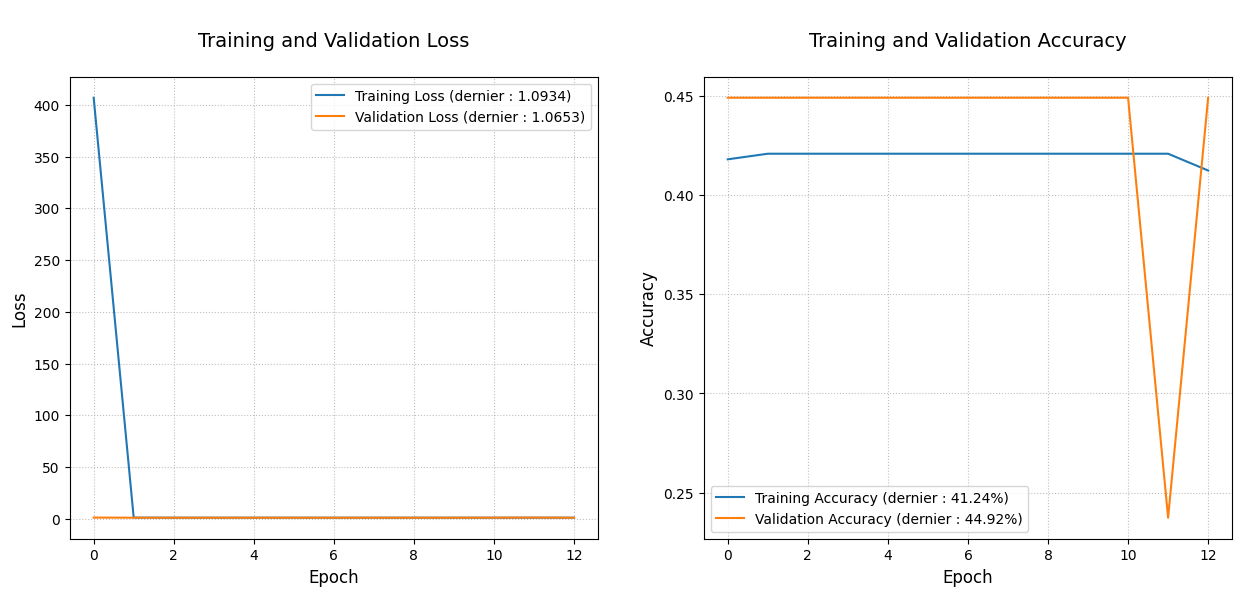

In [21]:
show_train_metrics(history=history_opti)

In [22]:
# Score du dernier epoch
print("=== Dernier epoch ===")
loss, accuracy = model_opti.evaluate(dataset_train, verbose=False)
print(f"Training Accuracy   : {accuracy:.3f}")
loss, accuracy = model_opti.evaluate(dataset_val, verbose=False)
print(f"Validation Accuracy : {accuracy:.3f}")

# Score de l'epoch optimal
print("=== Epoch optimal ===")
# Chargement des poids optimaux
model_opti.load_weights(model_opti_save_path)
loss, accuracy = model_opti.evaluate(dataset_val, verbose=False)
print(f"Validation Accuracy : {accuracy:.3f}")
loss, accuracy = model_opti.evaluate(dataset_test, verbose=False)
print(f"Test Accuracy       : {accuracy:.3f}")

=== Dernier epoch ===
Training Accuracy   : 0.421
Validation Accuracy : 0.449
=== Epoch optimal ===
Validation Accuracy : 0.449
Test Accuracy       : 0.427


=== Scores pour les prédictions ===
Accuracy score : 0.427
Precision score : 0.183
Recall score : 0.427
F1 score : 0.256


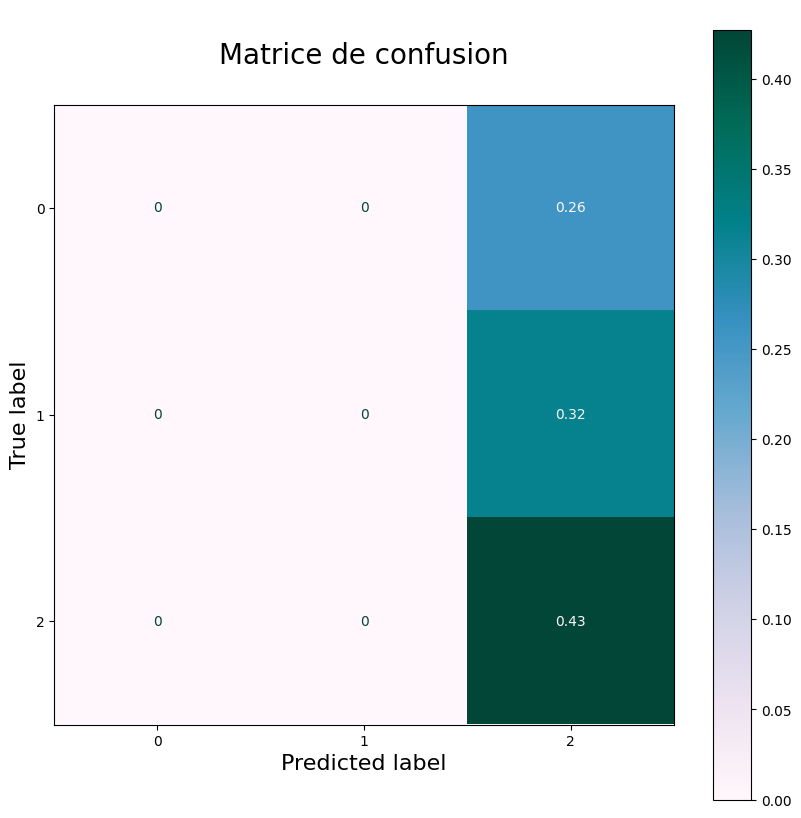

In [23]:
show_metrics_and_matrix(model=model_opti, dataset=dataset_test)

### **Mesure de la durée d'exécution du notebook**

In [24]:
temps_secondes = time.time() - t_notebook

# Conversion en minutes et secondes
minutes = int(temps_secondes // 60)
seconds = int(temps_secondes % 60)

# Formatage du résultat
formatted_time = f"{minutes:02}:{seconds:02}"

print(f"Durée d'exécution du notebook (hors imports) : {formatted_time}")

Durée d'exécution du notebook (hors imports) : 02:02
